<div align="center">

# 🧠 Machine Learning Models

###  **Artin Tavasoli** 👋🏻 
📘 **Student ID:** `810102543`

</div>



<span style="font-size:30px; font-weight:bold; color:pink;">📚 Import Needed Libraries</span>


In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.model_selection import GridSearchCV


<span style="font-size:30px; font-weight:bold; color:pink;">⏳ Load Dataset</span>

In [53]:
grades_df = pd.read_csv('AI-Course-Grades.csv')

<span style="font-size:50px; font-weight:bold; color:pink;">📤 Data Preprocessing</span>


<span style="font-size:40px; font-weight:bold; color:pink;">🧩 Handling Missing Values</span>

<span style="font-size:30px; font-weight:bold; color:pink;">👻 Handle Absent Data</span>



In [54]:
print(grades_df.isnull().any())

university           False
sex                  False
age                  False
address              False
motherEducation      False
fatherEducation      False
motherJob            False
fatherJob            False
reason               False
travelTime           False
studyTime            False
failures             False
universitySupport    False
paid                 False
higher               False
internet             False
romantic             False
freeTime             False
goOut                False
Dalc                 False
Walc                 False
absences             False
EPSGrade             False
DSGrade              False
finalGrade           False
dtype: bool


<div align="left">
<span style="font-size:40px; font-weight:bold; color:pink;">❗ Handle Unassigned Values</span>

---
 

There are several strategies for dealing with missing data, each suited to different circumstances:

1. **Remove Rows with Missing Values**  
   Discard data points (rows) that have missing entries. While simple, this can be impractical if many rows have missing features or if those rows contain otherwise valuable information.

2. **Remove Columns with Missing Values**  
   Drop the entire feature (column) when only a small portion of the dataset contains values for it. Useful when the missing data renders the feature unreliable or irrelevant.

3. **Impute with Statistical Measures**  
   Fill missing values using statistical metrics such as the **mean**, **median**, or **mode** of the corresponding column. Maintains dataset size, though it may introduce bias.

4. **Predict Missing Values Using Machine Learning**  
   Use a supervised learning model (e.g., classification or KNN) to predict missing values based on patterns in the existing data. More sophisticated and potentially more accurate.

5. **Manual Imputation Based on Domain Knowledge**  
   Have domain experts assign missing values based on contextual understanding or existing labels.

</div>


In [55]:
print('number of unassigned values in 'f"{grades_df.shape[0]} data points")

print((grades_df == 'other').sum())

number of unassigned values in 397 data points
university             0
sex                    0
age                    0
address                0
motherEducation        0
fatherEducation        0
motherJob            142
fatherJob            217
reason                37
travelTime             0
studyTime              0
failures               0
universitySupport      0
paid                   0
higher                 0
internet               0
romantic               0
freeTime               0
goOut                  0
Dalc                   0
Walc                   0
absences               0
EPSGrade               0
DSGrade                0
finalGrade             0
dtype: int64



About 36% of motherJob and 55% of fatherJob values' are missing, removing these features is the best action here


In [56]:
del grades_df['motherJob']
del grades_df['fatherJob']
print((grades_df == 'other').sum())

university            0
sex                   0
age                   0
address               0
motherEducation       0
fatherEducation       0
reason               37
travelTime            0
studyTime             0
failures              0
universitySupport     0
paid                  0
higher                0
internet              0
romantic              0
freeTime              0
goOut                 0
Dalc                  0
Walc                  0
absences              0
EPSGrade              0
DSGrade               0
finalGrade            0
dtype: int64


<span style="font-size:40px; font-weight:bold; color:pink;">Assign Values to "reason" Feature</span>

---

## 1. Initial Assignment Based on Travel Time

- **Condition**: travel time < 15 minutes  
  - set `reason = "home"`

---

## 2. Split Data by University

Create two pandas DataFrames:

1. `df_CM`: all rows where `university == "CM"`  
2. `df_PR`: all rows where `university == "PR"`

---

## 3. Handle Remaining `"other"` Reasons

For each of `df_CM` and `df_PR`:

1. Select rows where `reason == "other"`.  
2. If `moderated_reason == "reputation"`, set `reason = "reputation"`.  
3. Otherwise, set `reason = "course"`.  


In [57]:
def assign_reasons(df):
    df['original_reason'] = df['reason']

    mask = df['reason'] == 'other'
    df.loc[mask, 'reason'] = np.where(
    df.loc[mask, 'travelTime'] == 1,
    'home',
    np.where(
        df.loc[mask, 'original_reason'] == 'reputation',
        'reputation',
        'course'
    )
    )


    mask = df['reason'] == 'other'
    reason_counts = df['reason'].value_counts()
    if reason_counts.get('reputation') > reason_counts.get('course'):
        df.loc[mask, 'reason'] = 'reputation'
    else:
        df.loc[mask, 'reason'] = 'course'
    df.drop(columns='original_reason', inplace=True)
    return df

df_cm = grades_df[grades_df['university'] == 'CM'].copy()
df_pr = grades_df[grades_df['university'] == 'PR'].copy()
df_cm = assign_reasons(df_cm)
df_pr = assign_reasons(df_pr)

print("CM head:\n", df_cm[['university','travelTime','reason']].head(), "\n")
print("PR head:\n", df_pr[['university','travelTime','reason']].head())
df_cm.to_csv('df_cm.csv', index=False)
grades_df = pd.concat([df_pr, df_cm], ignore_index=True)

CM head:
     university  travelTime  reason
349         CM           2  course
350         CM           3    home
351         CM           2  course
352         CM           1  course
353         CM           3    home 

PR head:
   university  travelTime  reason
0         PR           2  course
1         PR           1  course
2         PR           1    home
3         PR           1    home
4         PR           1    home


## 🧹 Clean Data

---

### 1. Classify **Absences** into 4 Groups

| Group | Absences Range   |
|-------|------------------|
| **0** | 0 – 2            |
| **1** | 3 – 5            |
| **2** | 6 – 9            |
| **3** | 10 or more       |

### 2. Classify **EPSGrade**, **DSGrade**, and **finalGrade** into 4 Groups

| Group | Grade Range      |
|-------|------------------|
| **0** | 10 or lower      |
| **1** | 10 – 14          |
| **2** | 14 – 17          |
| **3** | 17 or more       |


In [58]:
def classify_absences(number_of_absences):
    if number_of_absences <= 2:
        return 0
    elif number_of_absences <= 5:
        return 1
    elif number_of_absences <= 9:
        return 2
    else:
        return 3

def classify_grade(grade):
    if grade <= 10:
        return 0
    elif grade <= 14:
        return 1
    elif grade <= 17:
        return 2
    else:
        return 3

grades_df['absences'] = grades_df['absences'].apply(classify_absences)
grades_df['finalGrade'] = grades_df['finalGrade'].apply(classify_grade)

print(grades_df.head())

  university sex  age address  motherEducation  fatherEducation  reason  \
0         PR   F   18       U                4                4  course   
1         PR   F   17       U                1                1  course   
2         PR   F   15       U                1                1    home   
3         PR   F   15       U                4                2    home   
4         PR   F   16       U                3                3    home   

   travelTime  studyTime  failures  ... internet romantic freeTime goOut Dalc  \
0           2          2         0  ...       no       no        3     4    1   
1           1          2         0  ...      yes       no        3     3    1   
2           1          2         3  ...      yes       no        3     2    2   
3           1          3         0  ...      yes      yes        2     2    1   
4           1          2         0  ...       no       no        3     2    1   

   Walc  absences  EPSGrade  DSGrade  finalGrade  
0     1    

<span style="font-size:40px; font-weight:bold; color:pink;">Label Encoding</span>

---


In [59]:
cat_cols = grades_df.select_dtypes(include=['object','category']).columns.tolist()


for col in cat_cols:
    grades_df[col] = grades_df[col].astype('category')

for col in cat_cols:
    grades_df[col] = grades_df[col].cat.codes

print(grades_df.head())


   university  sex  age  address  motherEducation  fatherEducation  reason  \
0           1    0   18        1                4                4       0   
1           1    0   17        1                1                1       0   
2           1    0   15        1                1                1       1   
3           1    0   15        1                4                2       1   
4           1    0   16        1                3                3       1   

   travelTime  studyTime  failures  ...  internet  romantic  freeTime  goOut  \
0           2          2         0  ...         0         0         3      4   
1           1          2         0  ...         1         0         3      3   
2           1          2         3  ...         1         0         3      2   
3           1          3         0  ...         1         1         2      2   
4           1          2         0  ...         0         0         3      2   

   Dalc  Walc  absences  EPSGrade  DSGrade  finalG

<span style="font-size:40px; font-weight:bold; color:pink;">Train-Test-Split</span>

---


In [60]:
SPLIT_RATIO = 0.2
X = grades_df.drop('finalGrade', axis=1)
Y = grades_df['finalGrade']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT_RATIO, random_state=67, shuffle=True)
print('length X train is : ', len(X_train))
print('length X test is : ', len(X_test))

length X train is :  317
length X test is :  80


<span style="font-size:40px; font-weight:bold; color:pink;">Feature Correlation Heatmap</span>

---

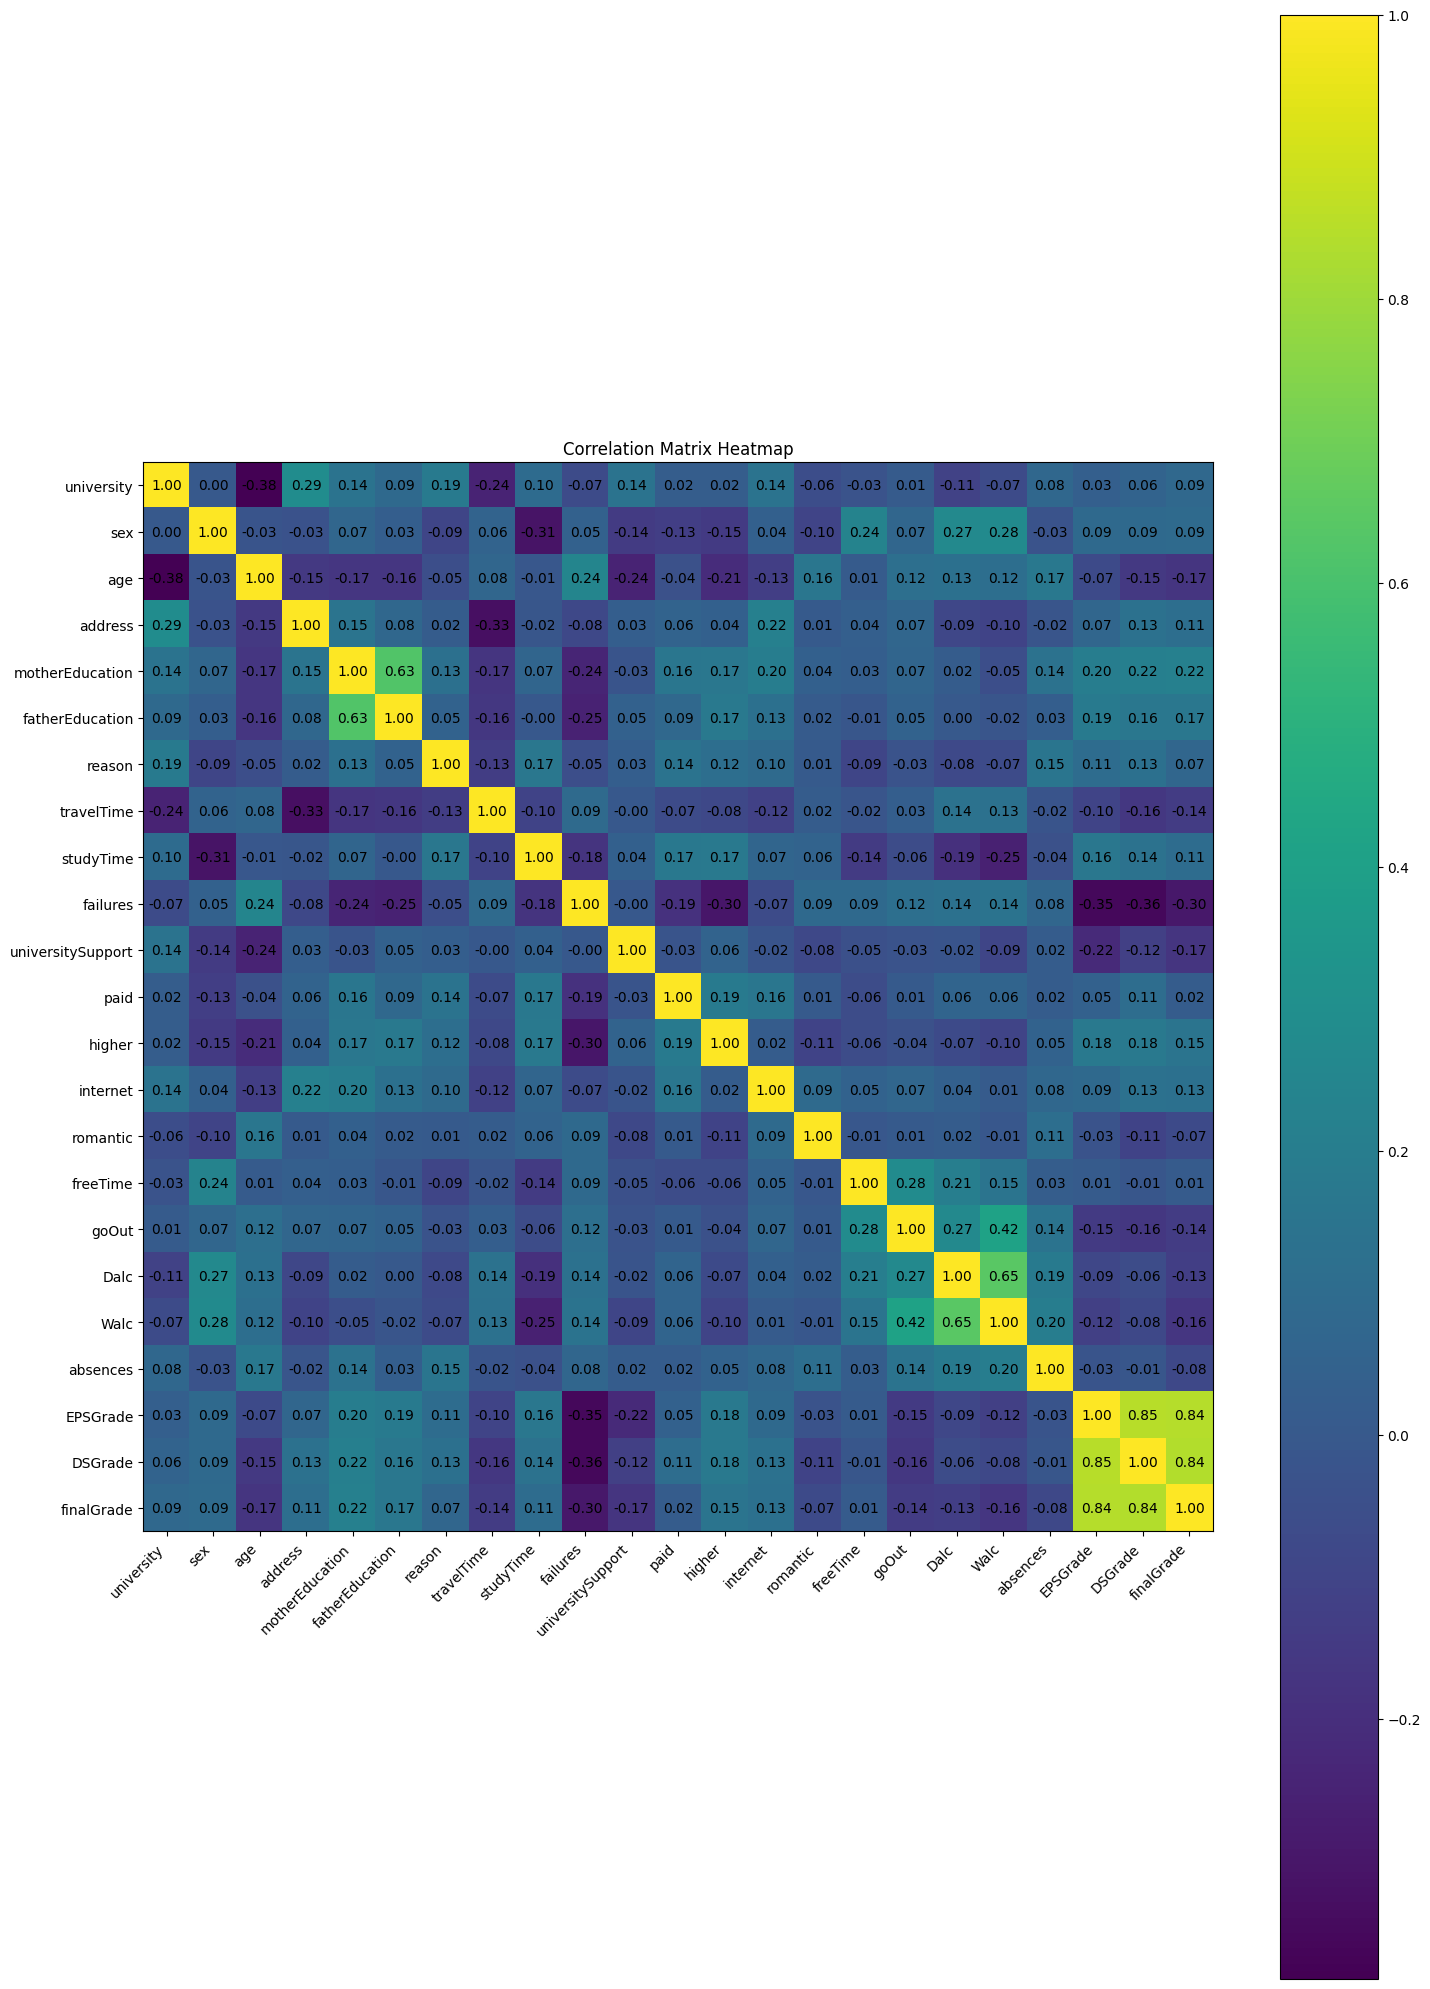

In [61]:
corr = grades_df.corr()
fig, ax = plt.subplots(figsize=(15, 20))
cax = ax.imshow(corr, interpolation='nearest')
cols = corr.columns
ax.set_xticks(range(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticks(range(len(cols)))
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(len(cols)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha='center', va='center')
plt.title('Correlation Matrix Heatmap')
plt.colorbar(cax)
plt.tight_layout()
plt.show()


EPSGrade and DSGrade are the two most correlated feature with finalGrade; plot a scatter figure using these two features

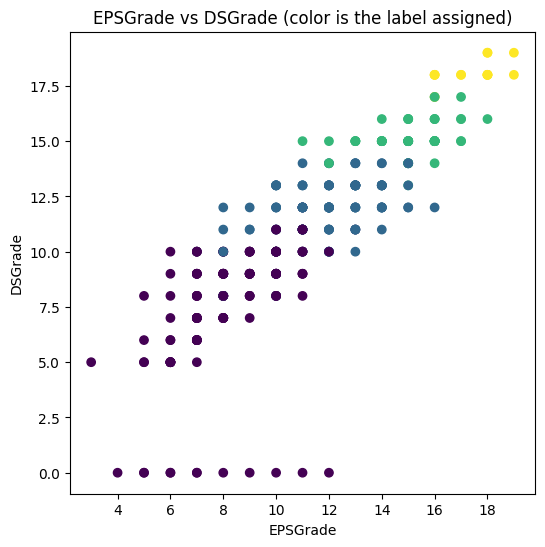

In [62]:
plt.figure(figsize=(6,6))
plt.scatter(X_train['EPSGrade'], X_train['DSGrade'], c=Y_train)
plt.xlabel('EPSGrade')
plt.ylabel('DSGrade')
plt.title(f"{'EPSGrade'} vs {'DSGrade'} (color is the label assigned)")
plt.show()

<span style="font-size:40px; font-weight:bold; color:pink;">Standardise Numerical Features</span>

---

## Why Standardization Is Important

Scaling ensures that features with large numeric ranges won’t dominate other features. Many machine learning models—especially those based on distance metrics (e.g., KNN)—are sensitive to feature scale. By scaling, we:

- Prevent biased features  
- Avoid slowed convergence  
- Achieve overall better performance  

## Methods

1. **Standardization**  
   Scales features to have a mean of 0 and a standard deviation of 1. Best when features are approximately Gaussian (normal distribution).

2. **Min–Max Scaling**  
   Scales features into the range [0, 1]. Good when you need bounded inputs but still want to preserve the original distribution.

3. **Robust Scaling**  
   Centers data around the median (median = 0) and scales according to the interquartile range (IQR = 1). Ideal when your data contains strong outliers.

4. **Logarithmic Transform**  
   Compresses large values and expands small ones to tame long tails, yielding a more symmetric distribution.

## Which Is Most Suited Here?

According to the observed scatter plot, we don’t have strong outliers and our feature values are fairly symmetric. Therefore:

- **Robust Scaling** and **Logarithmic Transform** are _not_ suited for our dataset.  
- We should focus on comparing **Standardization** and **Min–Max Scaling** for our analysis.


In [63]:
numerical_columns = ['age', 'EPSGrade', 'DSGrade']

# scaler = preprocessing.StandardScaler()
# grades_df[numerical_columns] = scaler.fit_transform(grades_df[numerical_columns])

scaler = preprocessing.MinMaxScaler()
grades_df[numerical_columns] = scaler.fit_transform(grades_df[numerical_columns])

grades_df[numerical_columns].head()

,age,EPSGrade,DSGrade
0,0.428571,0.1250,0.315789
1,0.285714,0.1250,0.263158
2,0.000000,0.2500,0.421053
3,0.000000,0.7500,0.736842
4,0.142857,0.1875,0.526316


<span style="font-size:40px; font-weight:bold; color:pink;"> 📊 Model Evaluation Methods</span>



---

## 1. Confusion Matrix

A **confusion matrix** shows the counts of:

|                    | Predicted Positive | Predicted Negative |
|--------------------|--------------------|--------------------|
| **Actual Positive**| True Positive (TP) | False Negative (FN)|
| **Actual Negative**| False Positive (FP)| True Negative (TN) |

> **What it tells you**  
> - **TP**: correctly identified positives  
> - **FP**: negatives incorrectly labeled as positives  
> - **TN**: correctly identified negatives  
> - **FN**: positives missed by the model  


## 2. Accuracy

> **Definition**  
> Measures the proportion of correctly classified instances out of all instances.

> $$ 
> \text{Accuracy} \;=\; \frac{\mathrm{TP} + \mathrm{TN}}{\mathrm{TP} + \mathrm{TN} + \mathrm{FP} + \mathrm{FN}} 
> $$

> **Why it’s easy but…**  
> Accuracy is **straight-forward** and intuitively appealing, but it can be **misleading** when classes are imbalanced.  

> **🚩 In our example:**  
> - We observed **high overall accuracy**,  
> - Yet the model performs **poorly on minority class B**, which accuracy alone fails to highlight.

---

<img src="P1.PNG" width="500"><br>


## 3. Precision, Recall & F1-Score

For **each class**:

> **Precision**  
> $$ 
> \text{Precision} \;=\; \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}} 
> $$

> **Recall**  
> $$ 
> \text{Recall} \;=\; \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}} 
> $$

> **F1-Score** (harmonic mean)  
> $$ 
> F_1 \;=\; 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
> $$

### Confusion Matrix Example

|                     | Predicted $\hat Y = 1$ | Predicted $\hat Y = 0$ |
| ------------------- | --------------------- | ----------------------- |
| **Actual $Y = 1$**  | TP = 60               | FN = 30               |
| **Actual $Y = 0$**  | FP = 20               | TN = 10               |

> - **Precision**: What fraction of predicted positives was correct?  
>   $$ \frac{60}{60 + 20} = 0.75 $$
>
> - **Recall**: What fraction of actual positives was found?  
>   $$ \frac{60}{60 + 30} = 0.667 $$


## 4. Averaging Methods

1. **Micro-average**  
   Aggregate all TP, FP, and FN across classes, then compute Precision & Recall once.  
   - Treats every instance equally.

2. **Macro-average**  
   Compute the metric **per class**, then take the unweighted mean.  
   - Treats every class equally, regardless of size.

3. **Weighted-average**  
   Like Macro, but weight each class’s metric by its support (number of instances).  
   - Balances the influence of large vs. small classes.

In [64]:
def evaluate_model(model_name, model, Y_test):

    preds = model.predict(X_test)

    cm = confusion_matrix(Y_test, preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    acc = accuracy_score(Y_test, preds)
    print(f"\n[{model_name}] Overall Accuracy: {acc * 100} %\n")

    class_labels = sorted(pd.unique(Y_test))
    rows = []
    for cls in class_labels:
        rows.append({
            'Class': cls,
            'Precision': precision_score(Y_test, preds, labels=[cls], average='macro'),
            'Recall':    recall_score(   Y_test, preds, labels=[cls], average='macro'),
            'F1-Score':  f1_score(       Y_test, preds, labels=[cls], average='macro')
        })
    df_per_class = pd.DataFrame(rows).set_index('Class')
    print("Per-Class Metrics:")
    display(df_per_class)

    summary = {}
    for avg in ('micro', 'macro', 'weighted'):
        summary[avg] = {
            'Precision': precision_score(Y_test, preds, average=avg),
            'Recall':    recall_score(   Y_test, preds, average=avg),
            'F1-Score':  f1_score(       Y_test, preds, average=avg)
        }
    df_summary = pd.DataFrame(summary).T
    df_summary.index.name = 'Average Type'
    print("\nSummary Averages:")
    display(df_summary)


<span style="font-size:40px; font-weight:bold; color:pink;"> 📊 Naive Bayes</span>

---

| Features Used                     | Accuracy   |
| --------------------------------- | ---------- |
| All Features                      | **71.25%** |
| Only `'EPSGrade'` and `'DSGrade'` | **88.75%** |

EPSGrade and DSGrade likely capture most of the essential information needed for classification. Adding more features introduced noise rather than useful signals.

Naive Bayes assumes feature independence and it was observed in heatmap that other features are weakly correlated with finalGrade but probably are dependant on other features

and adding them to model violates naive bayes rule and hurts performance.


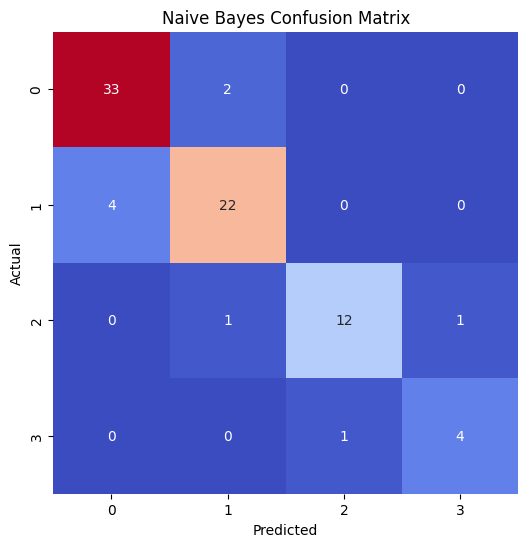


[Naive Bayes] Overall Accuracy: 88.75 %

Per-Class Metrics:


,Precision,Recall,F1-Score
Class,,,
0,0.891892,0.942857,0.916667
1,0.880000,0.846154,0.862745
2,0.923077,0.857143,0.888889
3,0.800000,0.800000,0.800000



Summary Averages:


,Precision,Recall,F1-Score
Average Type,,,
micro,0.887500,0.887500,0.887500
macro,0.873742,0.861538,0.867075
weighted,0.887741,0.887500,0.886989


In [65]:
# features_to_test = [
#     'university', 'sex', 'age', 'address',
#     'motherEducation', 'fatherEducation',
#     'reason', 'travelTime', 'studyTime', 'failures',
#     'universitySupport', 'paid', 'higher', 'internet',
#     'romantic', 'freeTime', 'goOut', 'Dalc', 'Walc',
#     'absences', 'EPSGrade', 'DSGrade'
# ]
features_to_test = ['EPSGrade', 'DSGrade']

X = grades_df[features_to_test]
Y = grades_df['finalGrade']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=SPLIT_RATIO,
    random_state=46,
    shuffle=True
)

nb_model = GaussianNB()
nb_model.fit(X_train, Y_train)
evaluate_model("Naive Bayes", nb_model, Y_test)



<span style="font-size:40px; font-weight:bold; color:pink;"> 📊 Decision Tree</span>

---

### ⚒️ Tuning Hyperparameters

#### 1. Criteria: Measures the quality of the split  

- **Gini impurity:** Splits the node in a way that yields the least amount of impurity.  
- **Information gain:** Uses the entropy measure to split a node in a way that it yields the most amount of information gain.  

#### 2. max_depth  
Controls the maximum depth to which the decision tree is allowed to grow.  

#### 3. min_samples_leaf  
Defines the required minimal amount of samples to be present at a leaf node.  

#### 4. ccp_alpha  
Considers a combination of **Cost** (Number of misclassifications) and **Complexity** (Number of nodes).  

The core idea is to iteratively drop sub-trees, which, after removal, lead to:  

- A minimal increase in classification cost  
- A maximum reduction of complexity (or nodes)  


### 🔍 Finding Optimal Hyperparameters using GridSearchCV: 

It exhaustively searches for the best hyperparameter combination.

What is cv in GridSearchCV:

When set to cv=5, it performs 5-fold cross-validation, meaning:

- (X_train, Y_train) is split into 5 equal parts (folds).

- The model is trained on 4 folds and tested on the remaining 1 fold.

- This process repeats 5 times, each time using a different fold for validation.

- The average accuracy across all 5 runs is calculated and used to determine the best hyperparameters

In [66]:
def create_optimal_tree(X_train, Y_train, grid, cv=5):
    dt = DecisionTreeClassifier(random_state=42)
    search = GridSearchCV(
        dt, grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_train, Y_train)
    print("Best hyperparameters:", search.best_params_)
    return search.best_estimator_


Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best hyperparameters: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.01}


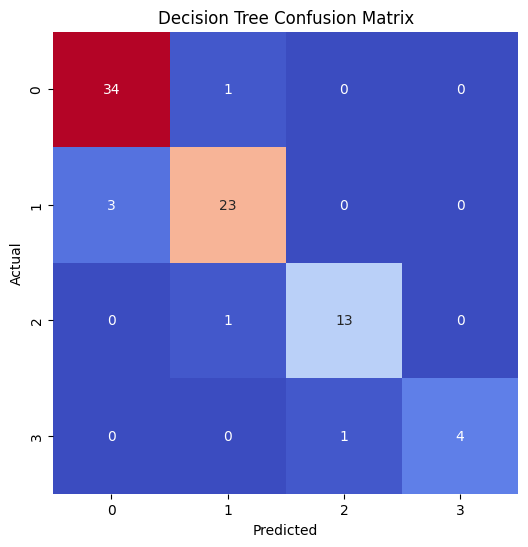


[Decision Tree] Overall Accuracy: 92.5 %

Per-Class Metrics:


,Precision,Recall,F1-Score
Class,,,
0,0.918919,0.971429,0.944444
1,0.920000,0.884615,0.901961
2,0.928571,0.928571,0.928571
3,1.000000,0.800000,0.888889



Summary Averages:


,Precision,Recall,F1-Score
Average Type,,,
micro,0.925000,0.925000,0.925000
macro,0.941873,0.896154,0.915966
weighted,0.926027,0.925000,0.924387


In [ ]:
features = [
    'university','sex','age','address','motherEducation','fatherEducation',
    'reason','travelTime','studyTime','failures','universitySupport','paid',
    'higher','internet','romantic','freeTime','goOut','Dalc','Walc',
    'absences','EPSGrade','DSGrade'
]
X = grades_df[features]
y = grades_df['finalGrade']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=SPLIT_RATIO, random_state=46, shuffle=True
)

param_grid = {
    'criterion':       ['gini', 'entropy'],
    'max_depth':       [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'ccp_alpha': [0.0, 0.01, 0.1],
}

DecisionTree = create_optimal_tree(X_train, Y_train, grid=param_grid)

evaluate_model("Decision Tree", DecisionTree, Y_test)


## 🌳 Plot Decision Tree


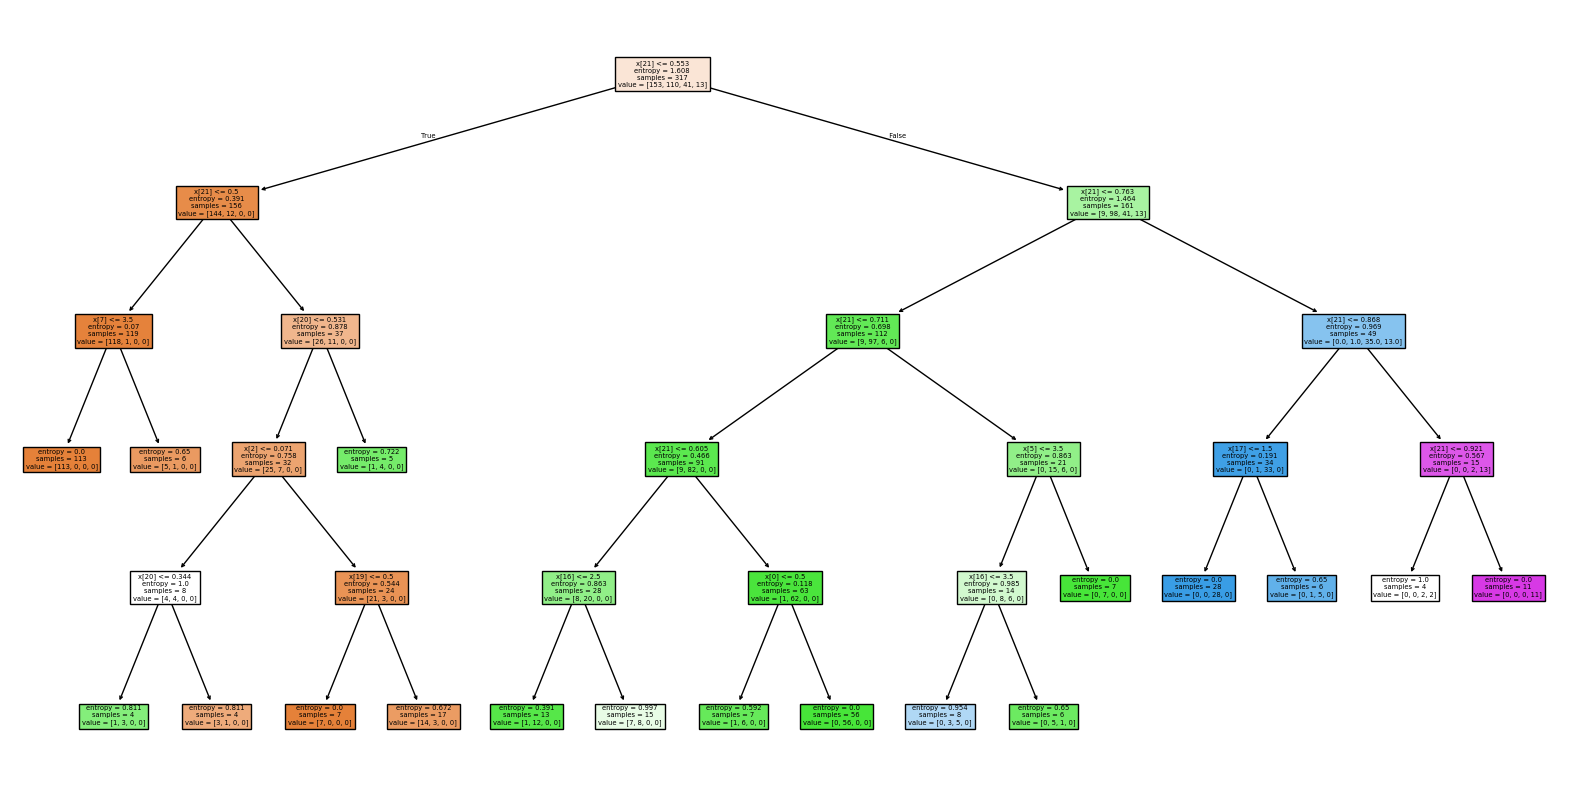

In [68]:
plt.figure(figsize=(20, 10))
plot_tree(DecisionTree, filled=True)
plt.show()